In [1]:
# Import modules

from music21 import *
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import itertools as iter

from dimod import BinaryQuadraticModel
import dimod.generators
from dwave.samplers import SteepestDescentSolver
from dwave.system import DWaveSampler, EmbeddingComposite

from calculators import *
from boundaryDetection import *
from graphUtilities import *
from graphPlotters import plotBoundaryStrength

In [2]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = "beethoven/opus74.mxl"

score = corpus.parse("haydn/opus1no1/movement1.mxl")
excerpt = score
identifier = "haydn_opus1no1_movement1"

#excerpt.show()

In [16]:
# Boundary detection

phraseLists = []
threshold = 0.3
weightings = (0.3, 0.6)

for part in excerpt.parts:
        print(f"Creating phrases for {part.id} part...")
        #plotBoundaryStrength(part, threshold, weightings)
        phrases = extractPhrases(part, threshold, weightings, f"{part.id}")
        print(f"{len(phrases)} phrases created!")
        phraseLists.append(phrases)

pickle.dump(phraseLists, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))

Creating phrases for Violin I part...
39 phrases created!
Creating phrases for Violin II part...
42 phrases created!
Creating phrases for Viola part...
31 phrases created!
Creating phrases for Cello part...
39 phrases created!


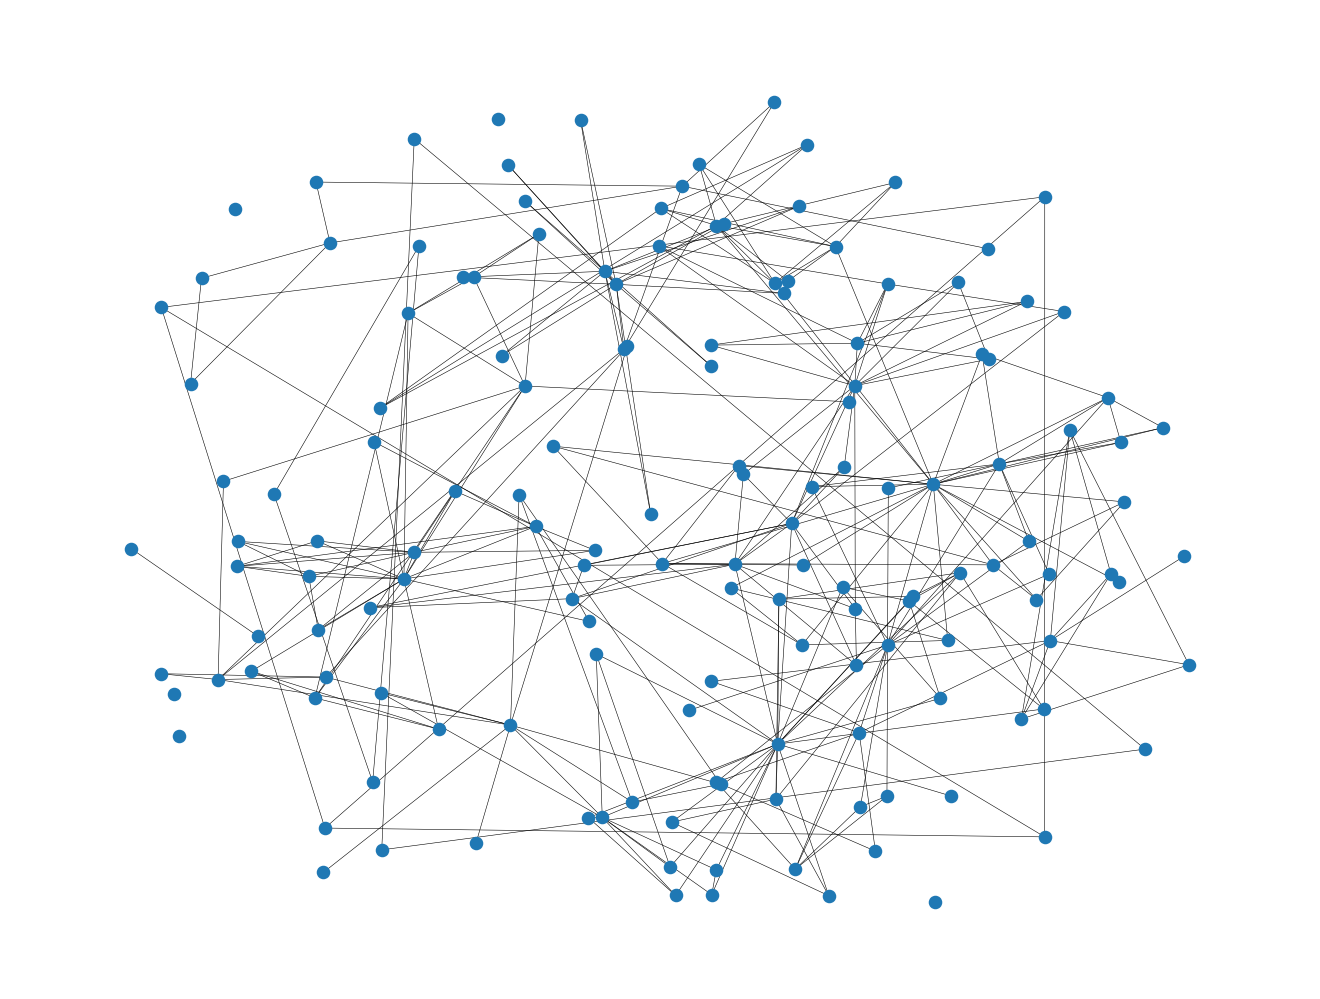

In [3]:
phraseLists = pickle.load(open(f"../Pickles/{identifier}_phrases.pkl", "rb"))
G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw(G, pos=pos, node_size=15, width=0.2)

In [5]:
phraseEntropies = [(phrase.id, phrase.entropy + 1) for part in phraseLists for phrase in part]
bqm = dimod.generators.maximum_weight_independent_set(G.edges, phraseEntropies, strength_multiplier=2)
print(bqm)

BinaryQuadraticModel({'Violin I_1': -3.7024549619059113, 'Violin II_1': -3.976216224524763, 'Viola_1': -3.5, 'Cello_1': -3.5418848434970744, 'Cello_2': -1.0, 'Violin I_2': -1.0, 'Violin I_3': -3.7736843762620236, 'Violin II_3': -4.576911051568265, 'Viola_3': -3.5, 'Viola_4': -1.0, 'Cello_3': -3.377443751081734, 'Cello_4': -1.0, 'Violin I_4': -1.0, 'Violin I_5': -4.353240480262612, 'Violin II_4': -2.0, 'Violin II_5': -1.0, 'Violin II_6': -1.9182958340544896, 'Violin II_7': -1.0, 'Violin II_8': -3.7527152789797045, 'Violin II_9': -1.0, 'Violin II_10': -4.146852406035913, 'Viola_5': -4.029423942181381, 'Viola_6': -1.0, 'Viola_7': -4.267462841284266, 'Viola_8': -1.0, 'Viola_9': -2.4366664819166877, 'Cello_7': -2.0, 'Cello_8': -1.0, 'Cello_9': -3.892878689342031, 'Cello_10': -3.0, 'Cello_11': -1.0, 'Cello_12': -1.0, 'Cello_13': -3.5, 'Cello_14': -1.0, 'Cello_15': -1.9940302114769564, 'Violin I_6': -1.0, 'Violin I_7': -2.918295834054489, 'Violin I_8': -1.0, 'Violin I_9': -4.8689641616684, 'V

In [39]:
# Create colouring problem BQM

bqm = BinaryQuadraticModel(vartype="BINARY")

colours = {0:"red", 1:"green", 2:"blue"}
allPhrases = [phrase for part in phraseLists for phrase in part]

# Add all vertices for each colour
bqm.add_variables_from([(f"{phrase.id}_{i}", 0)for phrase in allPhrases for i in colours])

for phrase in allPhrases:
    # Each vertex coloured at most once
    bqm.add_linear_inequality_constraint([(f"{phrase.id}_{i}",1) for i in colours], ub=1, lagrange_multiplier=10, label="One colour per vertex")
    # Maximise vertex weighting
    bqm.add_linear_from([(f"{phrase.id}_{i}", -phrase.entropy) for i in colours])

for u, v, d in G.edges.data():
    # Adjacent vertices have different colours
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{i}", 100) for i in colours])
    # Maximise edge weighting
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{j}", -d["weight"]) for i,j in iter.product(colours, repeat=2)])


# Solve classically
df = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

In [ ]:

set0 = [node for node in chosen if chosen[node] == "red"]
set1 = [node for node in chosen if chosen[node] == "green"]
set2 = [node for node in chosen if chosen[node] == "blue"]

pos_0 = nx.circular_layout(G.subgraph(set0), center=(-3, -0.5))
pos_1 = nx.circular_layout(G.subgraph(set1), center=(3, 1))
pos_2 = nx.circular_layout(G.subgraph(set2), center=(0, 1))

pos = {**pos_0, **pos_1, **pos_2}

plt.figure(1)
nx.draw_networkx_nodes(G, pos_0, nodelist=set0, node_color="red")
nx.draw_networkx_nodes(G, pos_1, nodelist=set1, node_color="green")
nx.draw_networkx_nodes(G, pos_2, nodelist=set2, node_color="blue")
nx.draw_networkx_edges(G, pos, width=0.2)

                                                sample      energy  \
678  {'Cello_10_0': 1, 'Cello_10_1': 0, 'Cello_10_2... -184.752483   
747  {'Cello_10_0': 0, 'Cello_10_1': 0, 'Cello_10_2... -167.967579   
568  {'Cello_10_0': 1, 'Cello_10_1': 0, 'Cello_10_2... -167.483085   
956  {'Cello_10_0': 0, 'Cello_10_1': 1, 'Cello_10_2... -155.057690   
940  {'Cello_10_0': 0, 'Cello_10_1': 0, 'Cello_10_2... -153.449760   

     num_occurrences  num_steps  
678                1        152  
747                1        128  
568                1        142  
956                1        153  
940                1        141  


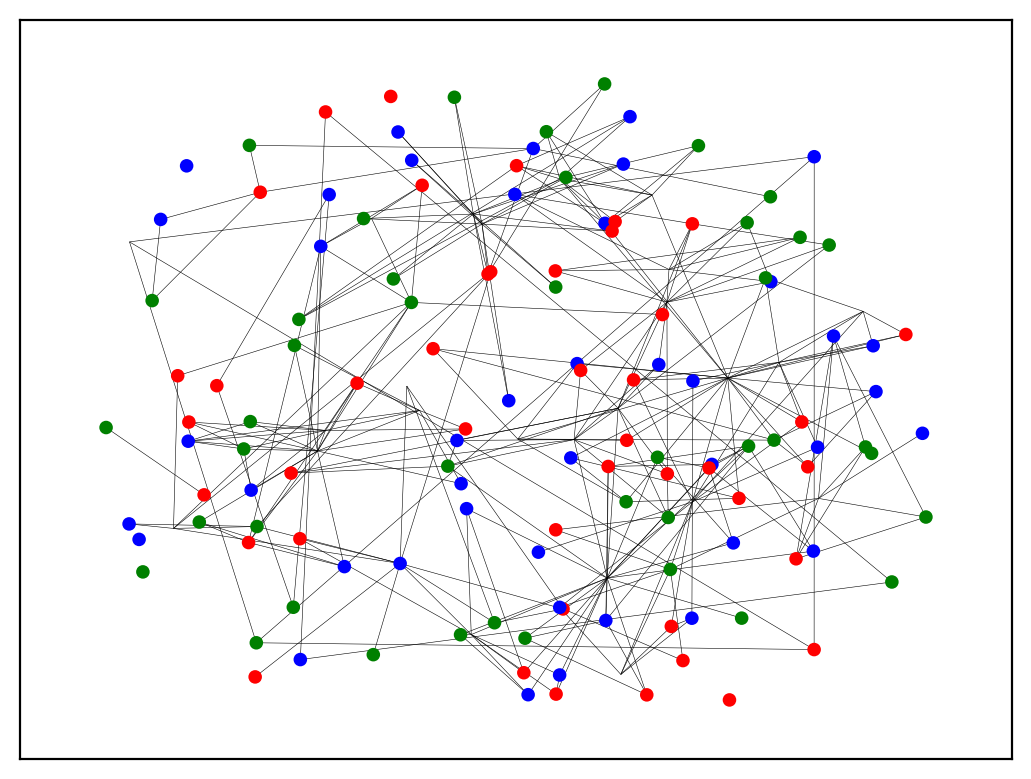

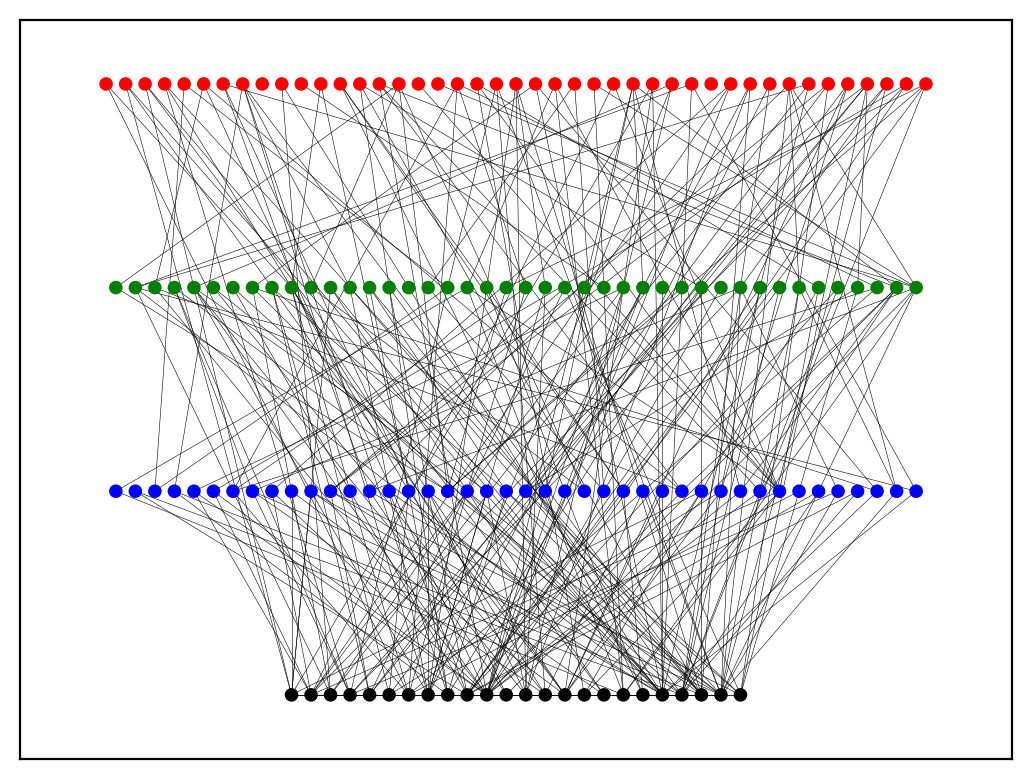

In [40]:
import re

# Show results
colours = {0:"red", 1:"green", 2:"blue"}
def processNode(node):
    groups = re.match(r"(.*_\d+)_(\d+)", node).groups()
    return (groups[0], colours[int(groups[1])])

#print(df.head())
print(df.sort_values("energy").head())

sample = df["sample"][0]
chosen = {processNode(x)[0]:processNode(x)[1] for x in sample if sample[x] == 1}

plt.figure(0)
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw_networkx_edges(G, pos, width=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=chosen.keys(), node_color=chosen.values(), node_size=15)

plt.figure(2)

for node in G.nodes():
    if node in chosen:
        G.nodes[node]["colour"] = chosen[node]
    else:
        G.nodes[node]["colour"] = "black"
pos = nx.multipartite_layout(G, "colour", "horizontal", 2)

nx.draw_networkx_nodes(G, pos, node_color=[G.nodes[node]["colour"] for node in G.nodes()], node_size=15)
nx.draw_networkx_edges(G, pos, width=0.2)

In [ ]:
# Solve on QPU

def solveWeightedMIS(G: nx.Graph, weights: list[tuple] = [], sampler=EmbeddingComposite(DWaveSampler()), num_reads: int = 100, strength_multiplier: float = 2) -> pd.DataFrame:
    bqm = dimod.generators.maximum_weight_independent_set(G.edges, weights, strength_multiplier=strength_multiplier)
    sampler = sampler
    sampleset = sampler.sample(bqm, num_reads = num_reads)
    return sampleset.to_pandas_dataframe(True)

df = solveWeightedMIS(G, phraseEntropies, num_reads=1000)

In [ ]:
# Final arrangement

parts = {c:stream.Part() for c in colours.values()}
for phrase in [phrase for part in phraseLists for phrase in part]:
    if phrase.id in chosen:
        parts[chosen[phrase.id]].mergeElements(phrase.notes.stream()) # Focus on JUST NOTES for now 

arrangement = stream.Score(parts.values())

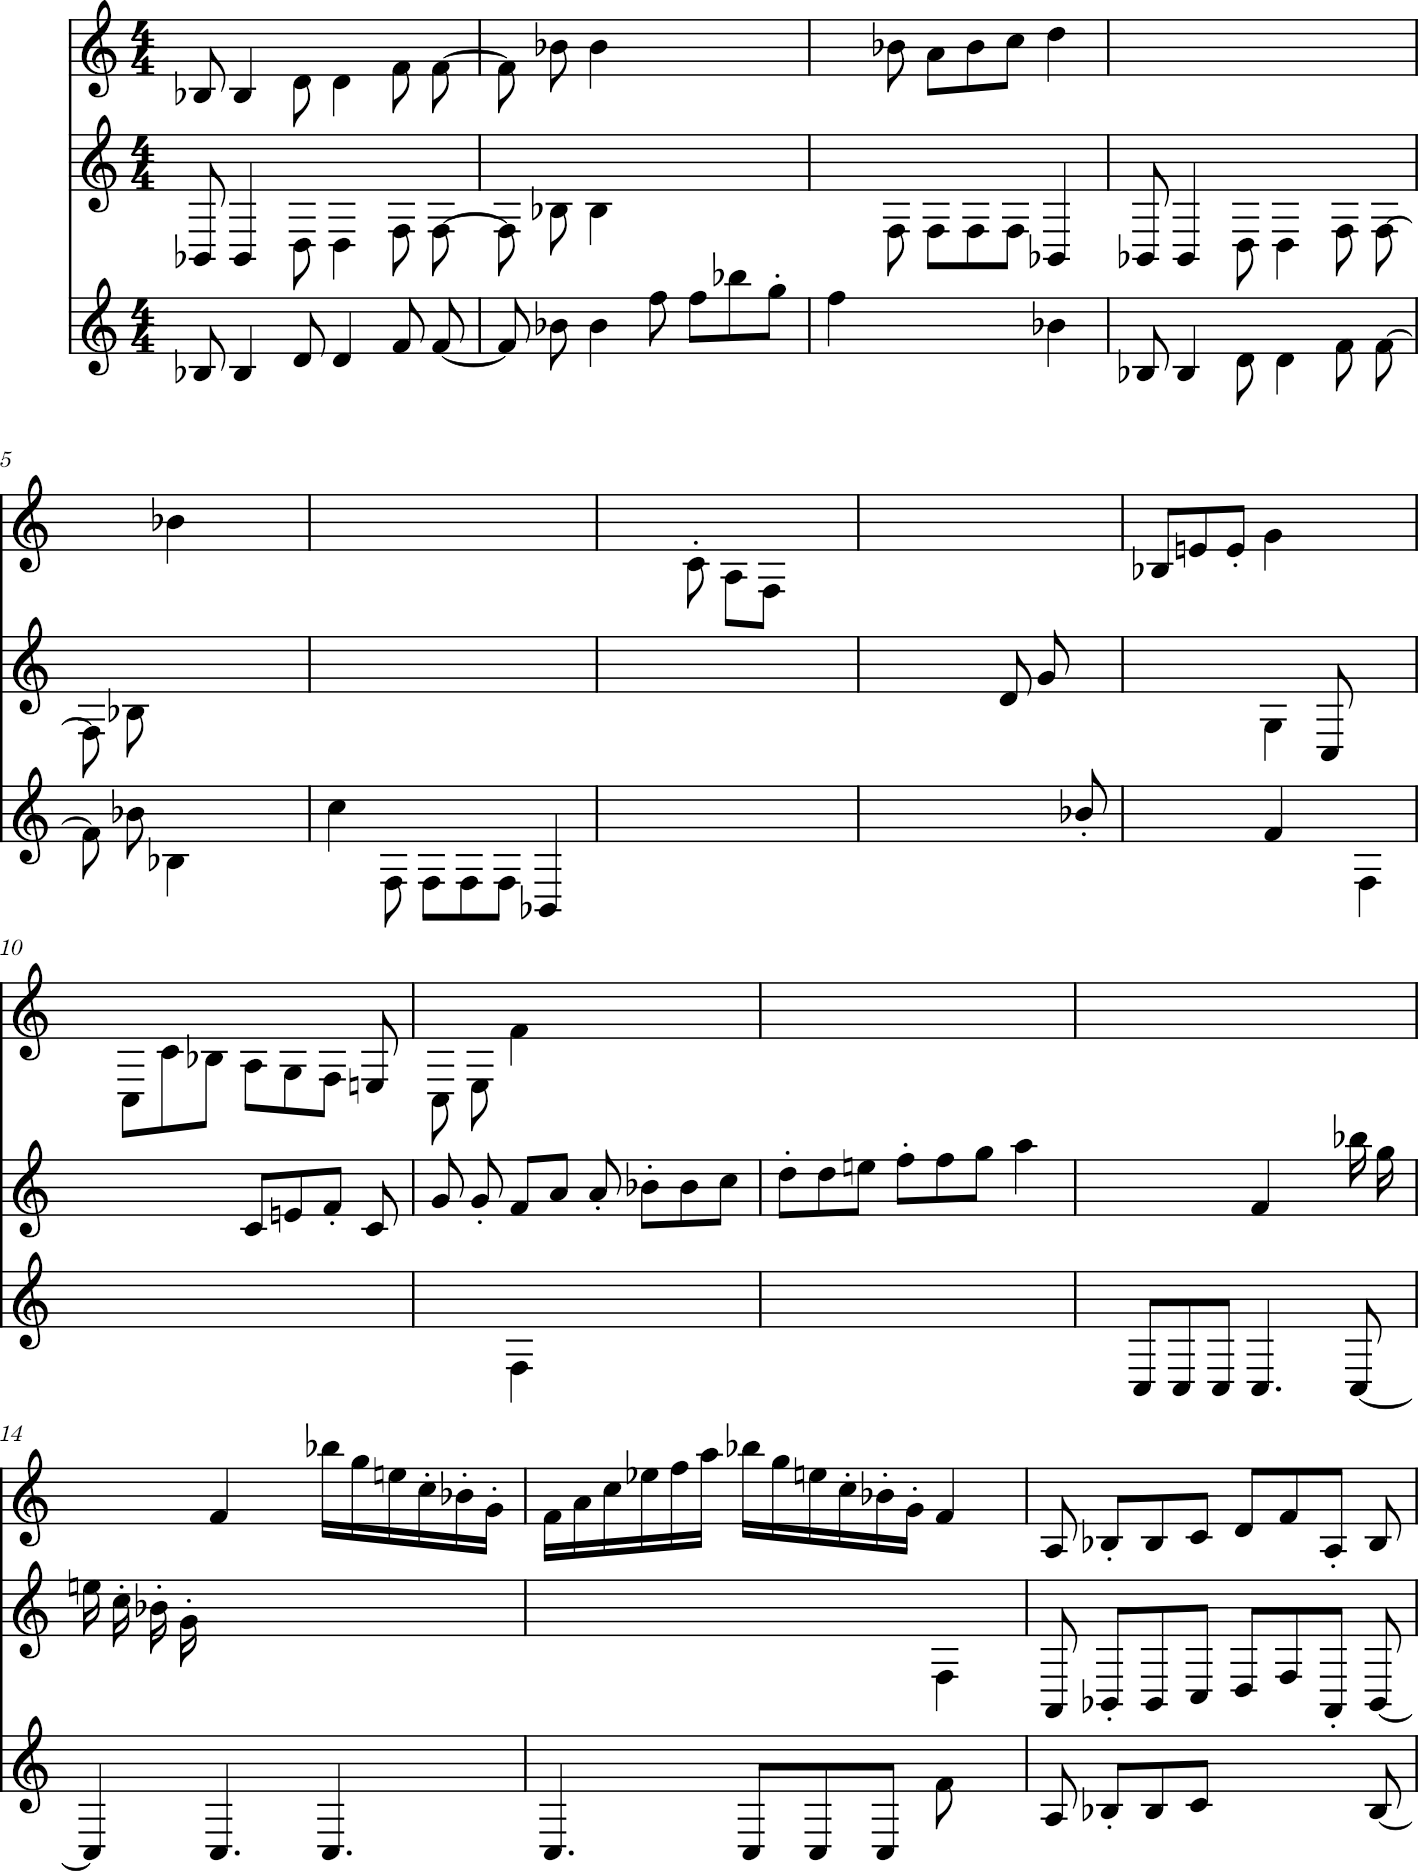

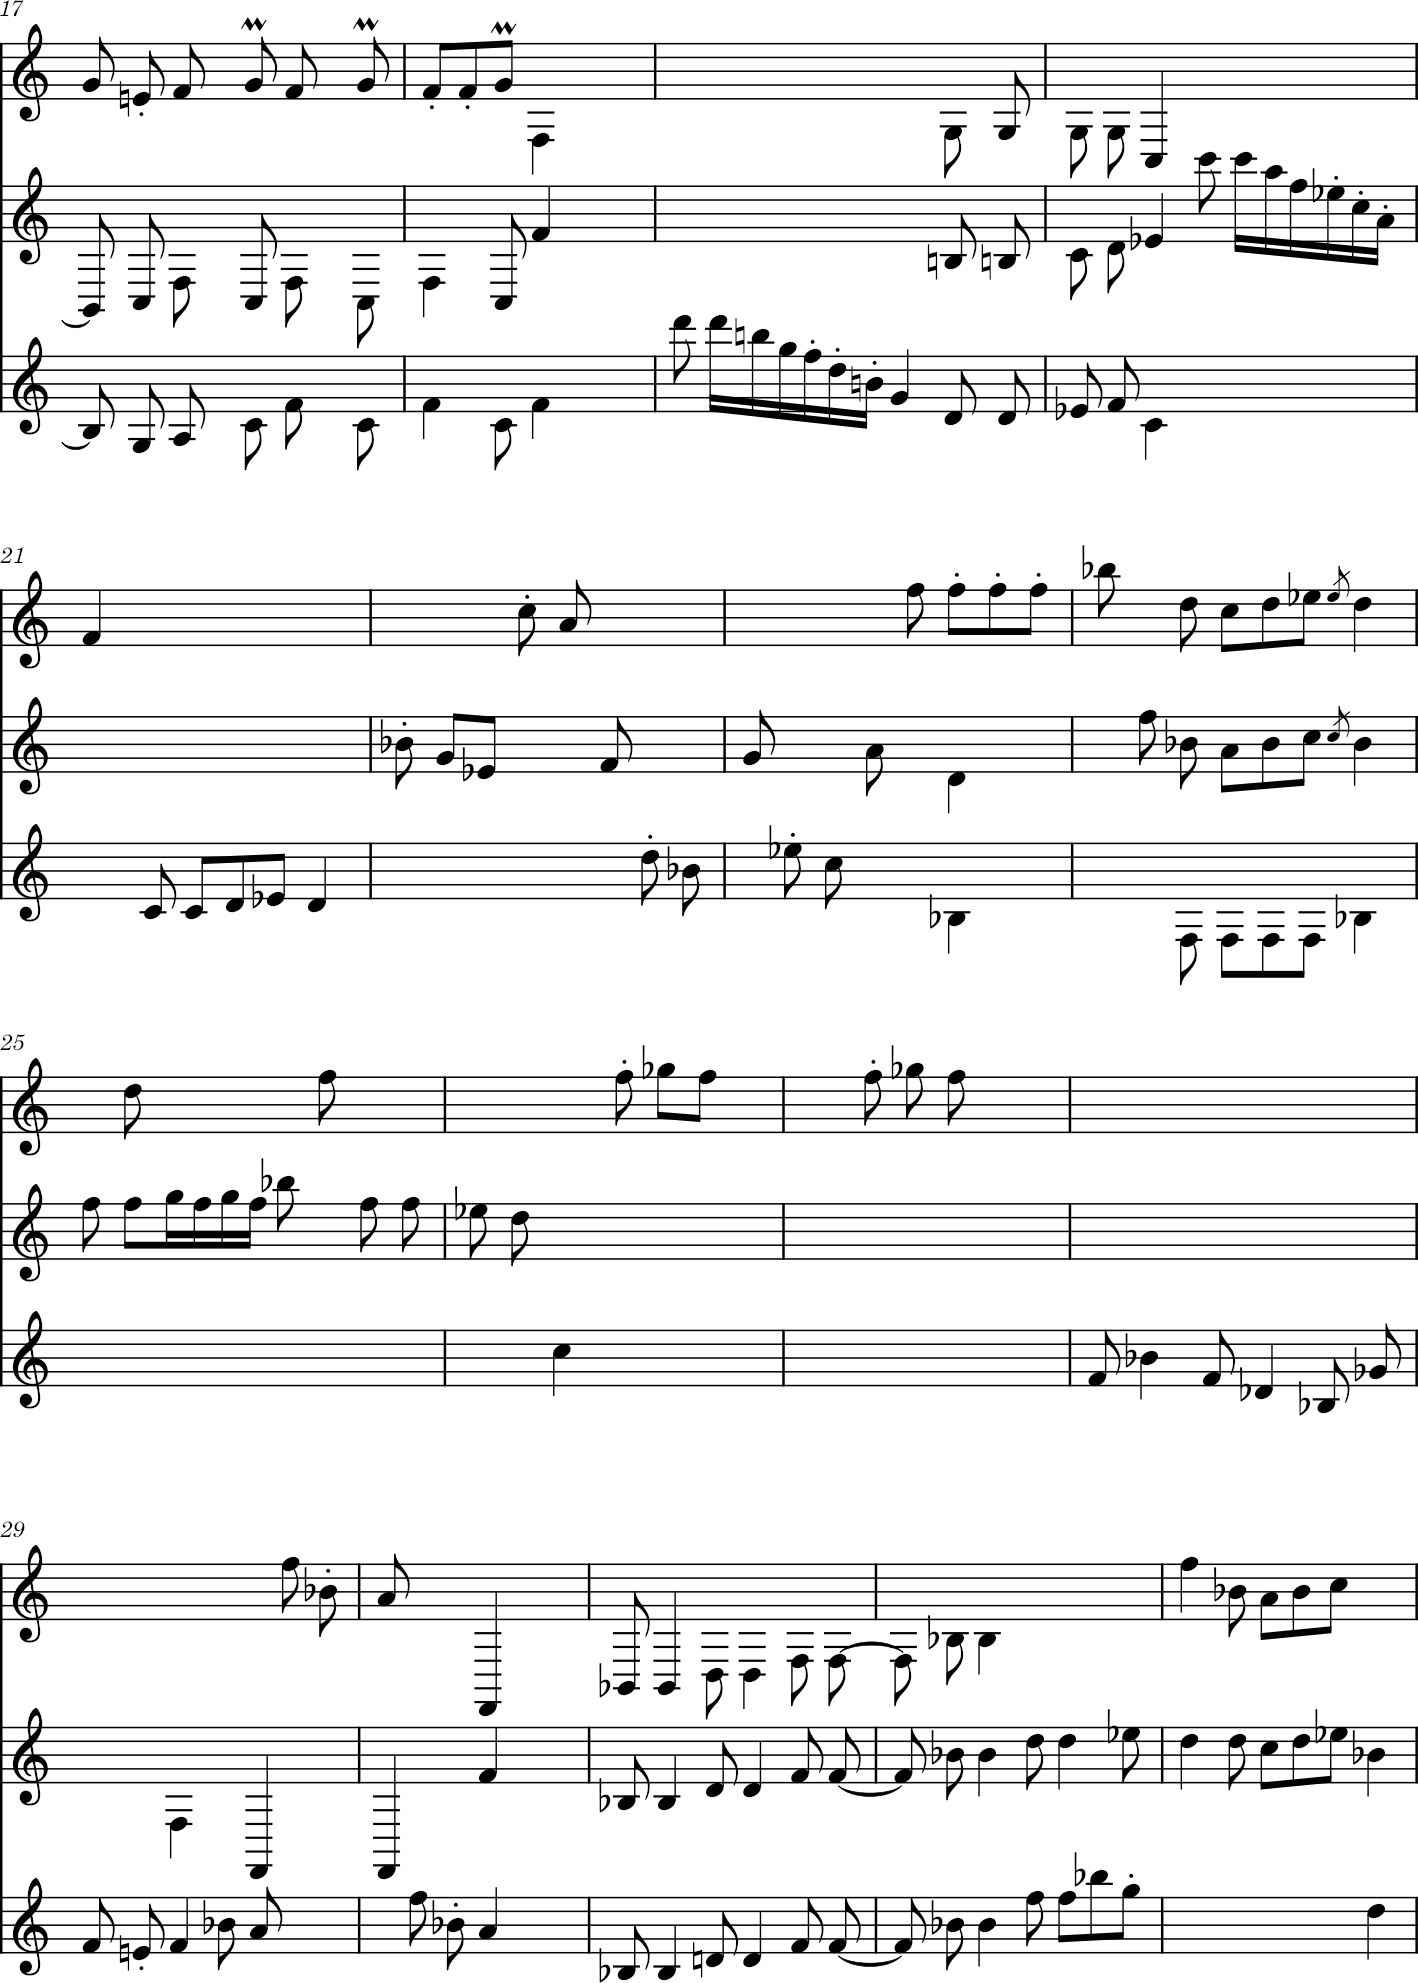

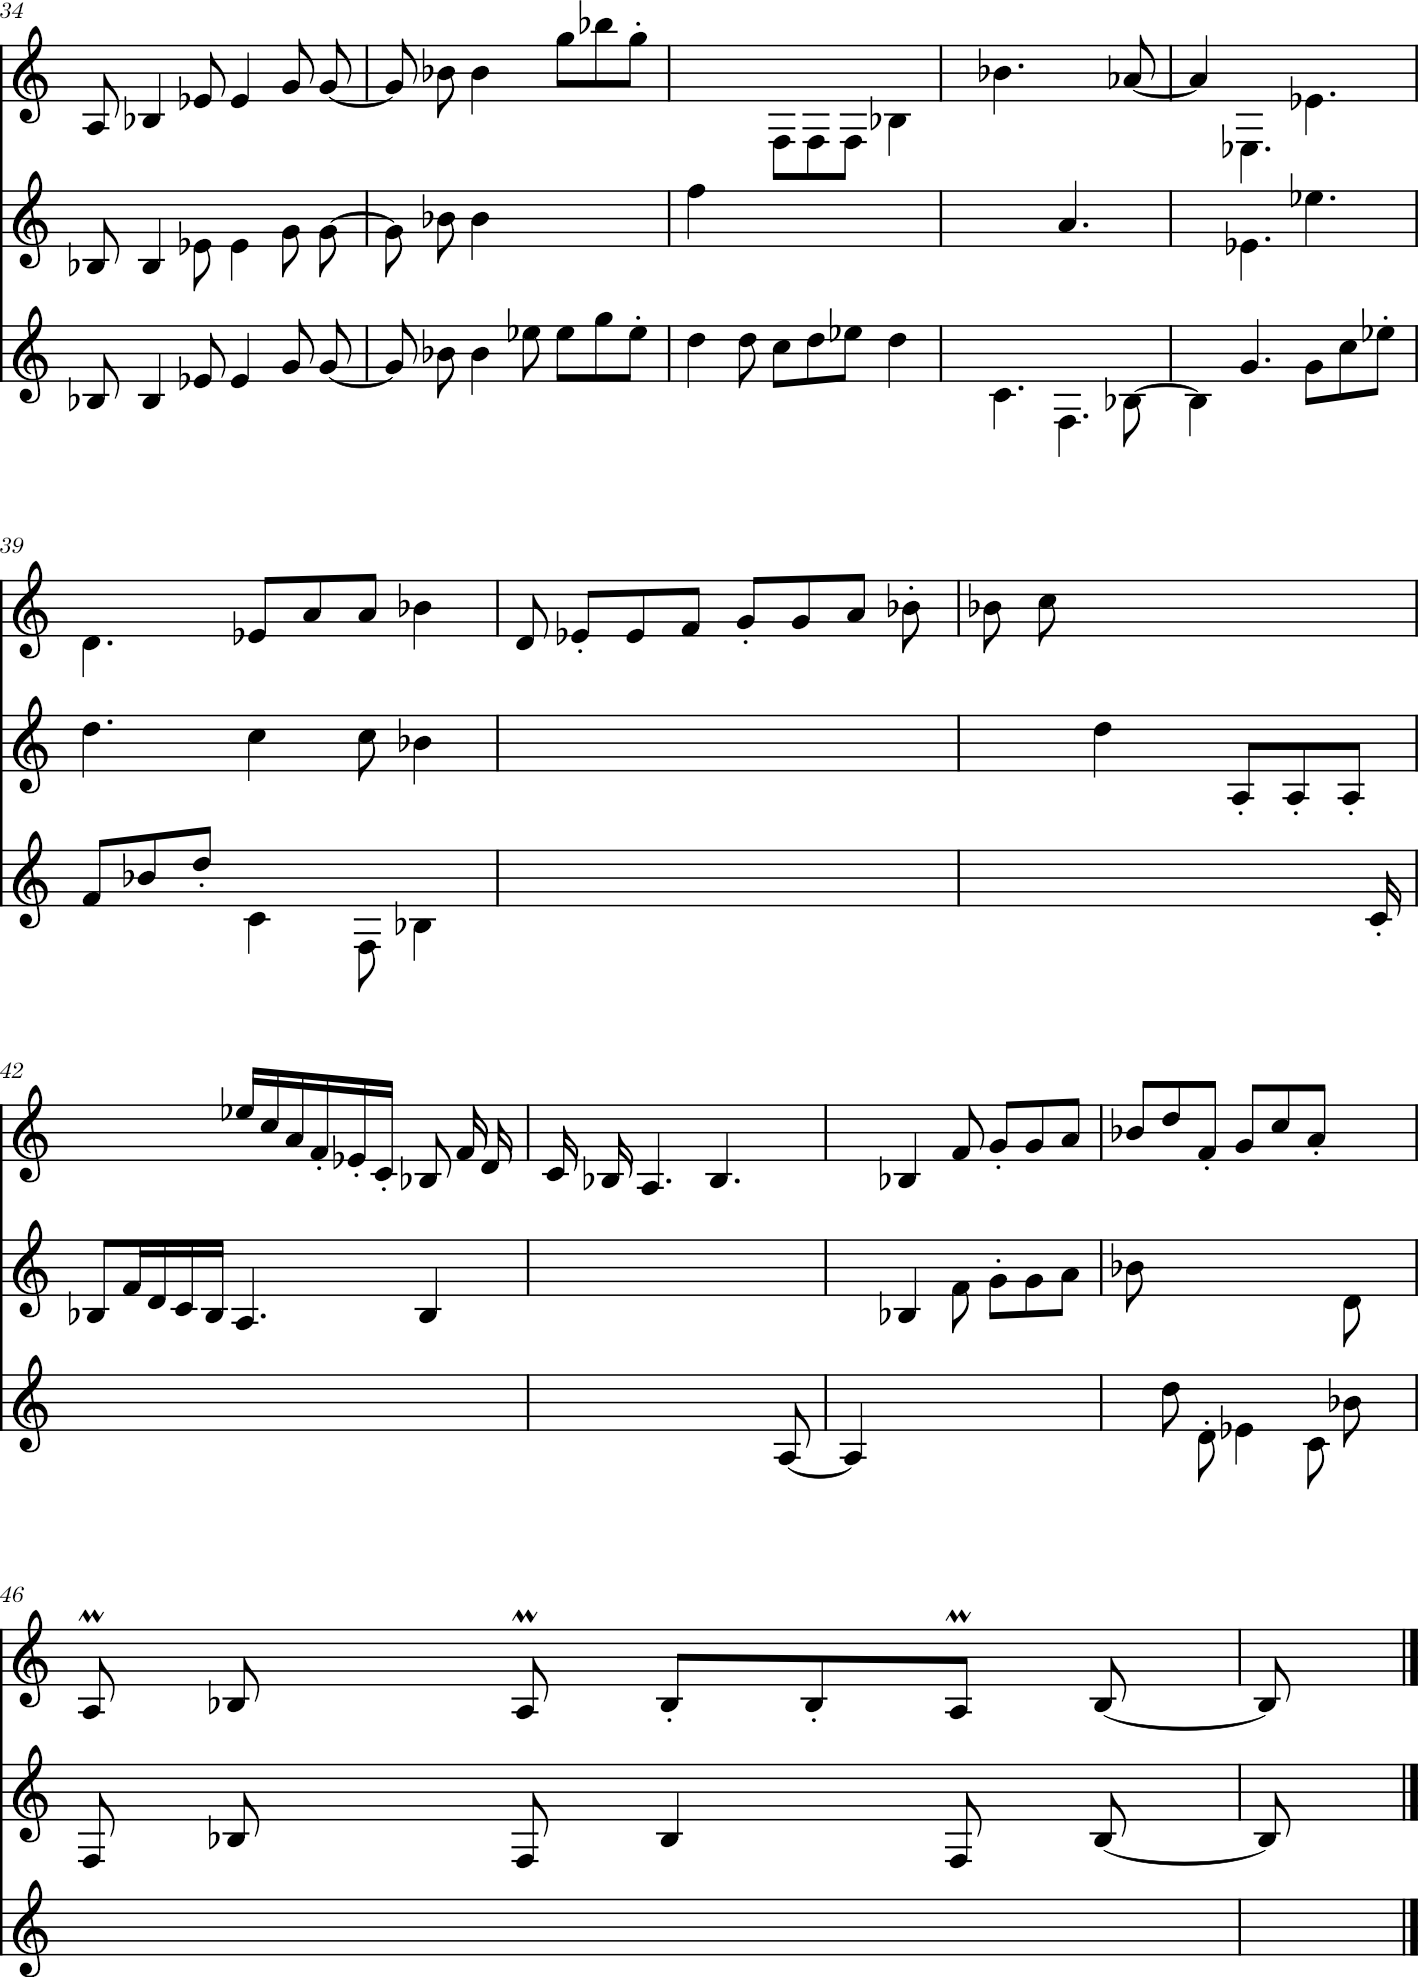

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/poly.pdf')

In [ ]:
arrangement.show("midi")
arrangement.show()
#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

In [38]:
# Save data

excerpt.write("xml", f"../Pickles/{identifier}_excerpt.xml")
pickle.dump(phraseLists, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))
pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))